# Introduction to ARMA Models with Financial Data

In [68]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.model_selection import train_test_split


We can use the yfinance package in python which uses Yahoo's publicly available API to pull data. We will pull the data for the S&P 500 using the ticker $SPY. We do this by creating a ticker object for spy. Once we have our ticker object (spy) we can access methods or attributes of the object such as history. The history method will allow us to pull historical data by defining some parameters including: 

- period: "1d”, “5d”, “1mo”, “3mo”, “6mo”, “1y”, “2y”, “5y”, “10y”, “ytd”, “max”
- interval: “1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”
- start: formatted as (yyyy-mm-dd) or datetime.
- end: formatted as (yyyy-mm-dd) or datetime.

Below we use the period and interval to define how far back we want the data and at what intervals from that period to current we want the data. Otherwise, we could also define start and end instead of period. 

In [69]:
spy = yf.Ticker("SPY")
hist = spy.history(period = "1y", interval= "1d")
df = pd.DataFrame(hist, columns=['Close'])
df.head

<bound method NDFrame.head of                                 Close
Date                                 
2022-03-28 00:00:00-04:00  448.314423
2022-03-29 00:00:00-04:00  453.860474
2022-03-30 00:00:00-04:00  451.057983
2022-03-31 00:00:00-04:00  444.115601
2022-04-01 00:00:00-04:00  445.374268
...                               ...
2023-03-21 00:00:00-04:00  398.910004
2023-03-22 00:00:00-04:00  392.109985
2023-03-23 00:00:00-04:00  393.170013
2023-03-24 00:00:00-04:00  395.750000
2023-03-27 00:00:00-04:00  396.489990

[251 rows x 1 columns]>

To begin any data analysis of time series data, it is useful to look at the trace plot, a historical plot of stock prices over time. 

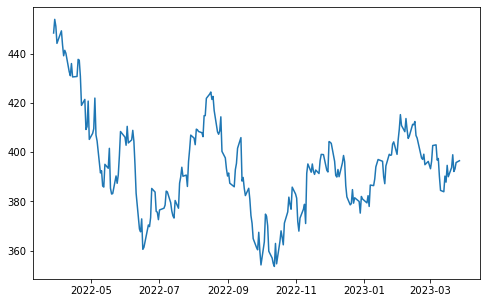

In [70]:
# add trace plot
plt.figure(figsize=(8,5))
plt.plot(df['Close'])

## Stationarity

In order for stationarity to be satsifed the following must be true: 

1) $E[X+t]$ does not depend on t. Thus there is constant mean. 

2) $var(X+t)$ does not depend on t. Thus there is constant variance.

3) $cov(X_t, X_{t+h})$ does not depend on t but only on $|{s-t}|$. That is, it only depends on the difference in times and not on the time itself. 

We can see in the above trace plot that stationarity is not satisfied. This is problematic in time series data because stationarity allows us to make valid statistical inferences about the time series data and leverage classical forecastign models such as ARIMA. 

There are methods we can employ to ensure stationarity such as differencing our data. Currently, our data are represented as $X_t$ where each time point has a stock price at close associated with it. However, we may be interested in differencing our data in order to achieve stationarity. For this, we are essentially subtracting the current observation by the previous in the following format to give us a new time series $Y_t$; 

$Y_t = X_t - X_{t-1}$

We can see that differencing removed any noticable trends or patterns in the plots below. As well, we could use a more fomal test, the Augmented Dickey-Fuller (ADF) Test to test a null hypothesis that the series is not stationary versus the alternative hypothesis that the series is stationary. This test confirms our visual results for the differenced data. 

Text(0, 0.5, 'difference price')

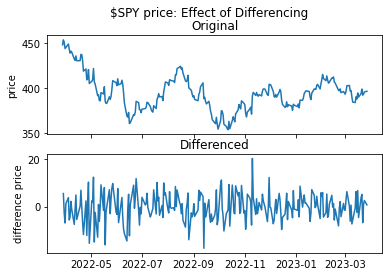

In [71]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('$SPY price: Effect of Differencing')

ax1.plot(df['Close'])
ax1.set_ylabel('price')
ax1.set_title('Original')

ax2.plot(df['Close'].diff())
ax2.set_title("Differenced")
ax2.set_ylabel('difference price')

In [72]:
from statsmodels.tsa.stattools import adfuller

def ADF_Cal(x):
    result = adfuller(x)
    ADF_stat = result[0]
    p = result[1]
    print("ADF Statistic: %f" % ADF_stat)
    print("p-value: %f" % p)
    print("Critical Values")
    levels = [.01, .05, .1]
    i = 0
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key,value))
        hyp = p < levels[i]
        if ADF_stat < value:
            cert = (1-levels[i])*100
            print("{}% certain this is stationary".format(cert))
            print('Reject H0: {}'.format(hyp))
            break
        i = i+1
        if i >= 3:
            print("Less than 90% certain that data is stationary")
            print('Reject H0: {}'.format(hyp))
print("Calculating ADF test for X...")

ADF_Cal(df['Close'].diff()[1:])

Calculating ADF test for X...
ADF Statistic: -16.307721
p-value: 0.000000
Critical Values
	1%: -3.457
99.0% certain this is stationary
Reject H0: True


## ACF & PACF Plots
We can use ACF, PACF and EACF Plots to give us an approximation of  an appropriate ARMA(p,q) model for the data. 

**ACF and PACF**

ACF is the autocovariance of lag h. Recall, for a stationary time series the covariance of difference time periods msut not depend on t but on |s - t|. That is, it is consistent between specific lags, *h*, which we define as |s-t|. 

$\gamma(h) = Cov(X_t, X_{t+h})$

So, if we want the autocovariance between observations $X_t$ and $X_{t-1}$ this is equivalent to: 

$\gamma(1) = Cov(X_t, X_{t-1})$ and we would expect this value to be there same between all observations which are 1 time unit (lag = 1) apart.  

PACF is the partial autocorrelation of lag h. The partial autocorrelation at lag *h* is the correlation between the time series data point at lag k and the same data point lagged by *h* time units, while controlling for the influence of all other data points between them.  For example, at lag 3, partial autocorrelation removes the effect lags 1 and 2 have on computing the correlation. We can roughly use the visual cues below to determine what appropriate cutoffs for our ARMA() model would be. 


|          | AR(p)               | MA(q)                 | ARMA(p,q)|
| :------: | :------:            | :------:              | :------: |
|     ACF  | tails off           | cuts off after lag q  | tails off|
|    PACF  |cuts off after lag p | tails off             | tails off|         

/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


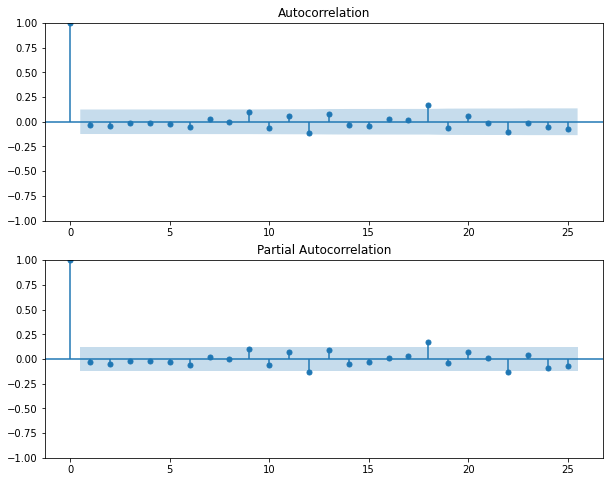

In [59]:
# Plot ACF and PACF
diff_ts = df['Close'].diff()[1:]
diff_ts

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(diff_ts, ax=ax1, lags = 25)
plot_pacf(diff_ts, ax=ax2, lags = 25)
plt.show()

## ARMA Model Fitting

We will fit an appropriate ARMA(p,q) model based on the above and the automated process of python's pmdarima auto_arima function. An ARMA(p,q) model has two components: AR(p) and MA(q). 

AR(p) refers to the autoregressive nature of the data. In the simplest case, this is equivalent to $X_t = \phi X_t-1 + W_t$. This model assigns weight $\phi$ to a previous observation and adds noise $W_t$, which generally we assume to be normally distributed. If we have several orders of the autoregressive component (p >=1), we can define the coefficients $phi_{1:n}$ within a characteristic polynomial such as: 

$X_t = \phi _1 X_{t-1} + ... +  \phi _pX_{t-p}$ can be rewritten as $\phi (B)X_t$ where $\phi(Z) = 1 -\sum_{j=1}^p  \phi _j z ^j$

With an example of an order 2, p = 2, ARMA(2) process below: 

$X_t = \phi _1 X_{t-1} + \phi _2 X_{t-2} + W_t$ which can be rewritten as $\phi (B)X_t$ where $\phi(Z) = 1 -\sum_{j=1}^2  \phi _j z ^j$ 


MA(q) refers to the moving average component of the data. In the simplest case we have $X_t = \theta W_{t-1} + W_t$. This model essentailly takes the average over a sliding window.If we have several orders of the moving average component (q >=1), we can define the coefficients $theta_{1:n}$ within a characteristic polynomial such as: 

$X_t = W_t +\theta _1 W_{t-1} + ... +  \theta _qX_{t-q}$ can be rewritten as $\theta (B)X_t$ where $\theta(Z) = 1 +\sum_{j=1}^p  \theta _j z ^j$


Combining the above, we reach the ARMA(p,q) model as follows: 

$X_t = \phi _1 X_{t-1} + ... + \phi _p X_{t-p} + W_t + \theta _1 W_{t-1} + ... +  \theta _qX_{t-q}$

which is equivalent to the following using characteristic polynomial notation as outlined above for AR(p) and MA(q) processes as 

$\phi(B) X_t = \theta(B)W_t$  

It is important to not that the differencing operation we applied to the data makes our ARMA(p,q) model on the differenced data series equivalent to running an ARIMA(p,d,q) model on the original data - where d is the order of differencing, 1 in this case. 

In [84]:
# fit model
model=pm.auto_arima(diff_ts,start_p=0,d=0,start_q=0,
          max_p=5,max_d=0,max_q=5, start_P=0,
          D=0, start_Q=0, max_P=5,max_D=0,
          max_Q=5, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1588.020, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1589.738, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1589.711, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1591.061, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1589.694, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.079 seconds


/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/danielherrera/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


In [89]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:                        SARIMAX   Log Likelihood                -793.010
Date:                Mon, 27 Mar 2023   AIC                           1588.020
Time:                        22:31:15   BIC                           1591.541
Sample:                             0   HQIC                          1589.437
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        33.3215      2.624     12.698      0.000      28.178      38.465
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 3.84
Prob(Q):                              0.58   Prob(JB):                         0.15
Heteroskedasticity (H):               0.43   Skew:                            -0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We see from the automated process above, as well as from our ACF and PACF plots which show no clear lagged patterns, that the ARMA model class may not be appropriate, as our best model is ARMA (0,0,0), which is a mean shifted white noise model. This may give us an indication that we may be dealing with a random walk process, which is quite commonplace for equities. 